In [1]:
import pandas as pd
import numpy as np
import json 
import re
import xml.etree.ElementTree as ET
import pickle
from pyhpo import Ontology
from fractions import Fraction
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats
_ = Ontology()


# Step 1: Read survey data

In [2]:
df_read = pd.read_csv('data/Survey_Random_Data.csv')

# Step 2: Clean and filter data
- Drop the unecessary columns: 'Unnamed: 0'
- Ignore cases has no one value
- Impose a minumum number of cases
- Create frequency table for diseases   

In [3]:
df = df_read.drop(['Unnamed: 0'], axis=1)
df = df.fillna(0)
rows_drop = df.loc[df.drop(['Disease_Name'], axis=1).sum(axis=1)==0].index
print('Number of the rows droped: ', len(rows_drop))
df.drop(df.loc[df.drop(['Disease_Name'], axis=1).sum(axis=1)==0].index, inplace=True)
col_drop = df.columns[df.sum()==0]
df.drop(columns=col_drop, inplace=True)
print('symptoms dropped which has no one value: ', list(col_drop))

Number of the rows droped:  26
symptoms dropped which has no one value:  ['Symptom 0']


In [4]:
df.head(5)

,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Symptom 6,Symptom 7,Symptom 8,Symptom 9,Symptom 10,...,Symptom 213,Symptom 214,Symptom 215,Symptom 216,Symptom 217,Symptom 218,Symptom 219,Symptom 220,Symptom 221,Disease_Name
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease 1
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Disease 1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease 1
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease 1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Disease 1


In [5]:
disease_cases_count = df.groupby('Disease_Name')['Disease_Name'].count()
#cases per disease
disease_cases_count

Disease_Name
Disease 1     56
Disease 10    55
Disease 11    65
Disease 12    69
Disease 2     67
Disease 3     49
Disease 4     65
Disease 5     90
Disease 6     67
Disease 7     63
Disease 8     60
Disease 9     68
Name: Disease_Name, dtype: int64

Impose a minimum number of cases

In [6]:
def count_if_enough_cases(x, n=5):
    if x.count()>=n:
        return np.count_nonzero(x)
    else:
        return np.nan

In [7]:
freq_table = df.groupby('Disease_Name').agg(count_if_enough_cases)
dis_disclosed = list(freq_table.loc[freq_table.isna().all(axis=1)].index)
print('Diseases have less than 5 cases: \n', dis_disclosed)
freq_table = freq_table.loc[~freq_table.isna().all(axis=1)]

Diseases have less than 5 cases: 
 []


In [8]:
rx_diseases = list(freq_table.index)
total_rx_diseases = len(freq_table)

# Step 3: Generate computational data
- Compute the specification of terms for diseases with Term Frequency(TF) and Inverse Document Frequency(IDF) information
- Get the very specific symptoms for diseases 
- Map the symptom to hpo terms

### Get the high specific symptoms from survey dataset

In [9]:
rx_impotant = freq_table.melt(ignore_index=False, var_name='Symptom', value_name='Count')
rx_impotant = rx_impotant.loc[rx_impotant['Count']>0]
rx_impotant['not_count'] = rx_impotant.apply(lambda x: disease_cases_count[x.name]-x.Count, axis=1)
rx_impotant['term_proportion'] = rx_impotant.apply(lambda x: x.Count/disease_cases_count[x.name], axis=1)

In [10]:
def IDF_compute(x, total_diseases):
    disease_per_term = x
    #print(x)
    IC_val = (np.log(total_diseases / (disease_per_term + 1)) + 1)
    return IC_val

In [11]:
#compute term frequency for each term/symtoms with diseases
total_disease_terms = freq_table.sum(axis=1)
rx_impotant['survey_frequency'] = rx_impotant.apply(lambda x: x['Count']/total_disease_terms[x.name], axis=1)

In [12]:
#compute idf for each term/symtoms with diseases
hpo_freq = rx_impotant.groupby('Symptom')['Count'].count()
hpo_idf = hpo_freq.apply(IDF_compute, total_diseases = total_rx_diseases)
rx_impotant['survey_idf'] = rx_impotant['Symptom'].apply(lambda x: hpo_idf[x])

In [13]:
#compute tf/idf of the terms with diseases
rx_impotant['survey_tf_idf'] = rx_impotant['survey_idf'] * rx_impotant['survey_frequency']

In [14]:
rx_impotant.sort_values('survey_tf_idf', ascending=False).head(10)

,Symptom,Count,not_count,term_proportion,survey_frequency,survey_idf,survey_tf_idf
Disease_Name,,,,,,,
Disease 3,Symptom 45,40,9,0.816327,0.400000,1.405465,0.562186
Disease 3,Symptom 28,34,15,0.693878,0.340000,1.538997,0.523259
Disease 3,Symptom 207,26,23,0.530612,0.260000,1.287682,0.334797
Disease 1,Symptom 18,35,21,0.625000,0.016957,1.693147,0.028711
Disease 1,Symptom 53,34,22,0.607143,0.016473,1.693147,0.027891
Disease 1,Symptom 146,29,27,0.517857,0.014050,1.875469,0.026351
Disease 1,Symptom 8,30,26,0.535714,0.014535,1.693147,0.024610
Disease 1,Symptom 78,32,24,0.571429,0.015504,1.538997,0.023860
Disease 1,Symptom 157,31,25,0.553571,0.015019,1.538997,0.023115


### Map the symptoms to HPO phenotypes 

In [15]:
df_hpo = pd.read_csv('data/symptoms_map_sim.csv')
hpo_map_symptom = dict(zip(df_hpo['Symptom'], df_hpo['Curated HPO']))
#hpo_map_symptom

In [16]:
rx_impotant['HPO_Code'] = rx_impotant['Symptom'].apply(lambda x: hpo_map_symptom[x].strip())
rx_impotant[['Symptom', 'HPO_Code']].value_counts().head(10)
rx_impotant['HPO_label'] = rx_impotant['HPO_Code'].apply(lambda x: Ontology.get_hpo_object(x).name)

### Get the high specific symptoms from hpo dataset

In [17]:
hpo_dataset = pd.read_csv('data/phenotype.txt', usecols=['DiseaseName', 'HPO_ID', 'Frequency'], sep='\t',
                                     encoding='ISO-8859-1',
                                     low_memory=False)
hpo_dataset = hpo_dataset.rename(columns={'DiseaseName':'Disease_Name', 'HPO_ID':'HPO_Code', 'Frequency': 'HPO_Frequency'})
hpo_dataset_null = hpo_dataset[hpo_dataset['HPO_Frequency'].isnull()]
hpo_dataset.loc[hpo_dataset['Disease_Name']=='Epileptic encephalopathy, early infantile, 42']
hpo_dataset = hpo_dataset[hpo_dataset['HPO_Frequency'].notnull()]

In [18]:
hpo_dataset.head(2)

,Disease_Name,HPO_Code,HPO_Frequency
14,"Mitochondrial complex II deficiency, nuclear t...",HP:0001332,1/1
15,"Mitochondrial complex II deficiency, nuclear t...",HP:0001250,1/1


In [19]:
#compute idf for each term with the disease with hpo dataset
freq_table_hpo_dataset = hpo_dataset.groupby('HPO_Code')['Disease_Name'].count()
total_hpo_diseases = len(hpo_dataset.Disease_Name.unique())
hpo_idf = freq_table_hpo_dataset.agg(IDF_compute, total_diseases = total_hpo_diseases)
rx_impotant['hpo_dataset_idf'] = rx_impotant['Symptom'].apply(lambda x: hpo_idf[hpo_map_symptom[x]] if hpo_map_symptom[x] in list(hpo_idf.keys()) else 0)

In [20]:
#combine two idf from survey and hpo
rx_impotant['survey_hpo_idf'] = rx_impotant['survey_idf'] + rx_impotant['hpo_dataset_idf']

In [21]:
#compute tf/idf of the terms with combined idf
rx_impotant['survey_hpo_tf_idf'] = rx_impotant['survey_hpo_idf'] * rx_impotant['survey_frequency']

In [22]:
rx_impotant.sort_values('survey_hpo_tf_idf', ascending=False).head(10)

,Symptom,Count,not_count,term_proportion,survey_frequency,survey_idf,survey_tf_idf,HPO_Code,HPO_label,hpo_dataset_idf,survey_hpo_idf,survey_hpo_tf_idf
Disease_Name,,,,,,,,,,,,
Disease 3,Symptom 45,40,9,0.816327,0.400000,1.405465,0.562186,HP:0011297,Abnormal digit morphology,8.002952,9.408417,3.763367
Disease 3,Symptom 28,34,15,0.693878,0.340000,1.538997,0.523259,HP:0001872,Abnormality of thrombocytes,7.517444,9.056441,3.079190
Disease 3,Symptom 207,26,23,0.530612,0.260000,1.287682,0.334797,HP:0000256,Macrocephaly,4.095941,5.383623,1.399742
Disease 1,Symptom 130,34,22,0.607143,0.016473,1.287682,0.021212,HP:0006479,Abnormal dental pulp morphology,8.290634,9.578316,0.157782
Disease 1,Symptom 209,32,24,0.571429,0.015504,1.405465,0.021790,HP:0000267,Cranial asymmetry,8.472955,9.878421,0.153154
Disease 1,Symptom 54,31,25,0.553571,0.015019,1.000000,0.015019,HP:0001787,Abnormal delivery,8.983781,9.983781,0.149950
Disease 1,Symptom 193,30,26,0.535714,0.014535,1.538997,0.022369,HP:0009725,Bladder neoplasm,8.696099,10.235095,0.148766
Disease 1,Symptom 8,30,26,0.535714,0.014535,1.693147,0.024610,HP:0002087,Abnormality of the upper respiratory tract,8.472955,10.166103,0.147763
Disease 1,Symptom 147,30,26,0.535714,0.014535,1.000000,0.014535,HP:0000080,Abnormality of reproductive system physiology,8.983781,9.983781,0.145113


In [23]:
rx_impotant.to_csv('data/RX_Task_1_TF_IDF.csv')

# Step 4: Compare RARE-X Data to Orphanet and HPO

Orphanet tracks phenotypes and symptoms for various rare diseases, with the following classifications:
 - Very frequent: more than 80% 
 - Frequent: between 30% and 80% 
 - Occasional: fewer than 30% 

In [24]:
tree = ET.parse('data/en_product4.xml')
root = tree.getroot()

In [25]:
# parse xml to dataframe
pf=[]
for child in root[1]:
    pf.extend([(child[0][2].text,p[0][1].text, p[1][0].text,p[0][0].text) for p in child[0][5]])
pheno_df = pd.DataFrame(pf,columns=['Disease_Name','Phenotype','Frequency','HPO_Code'])
pheno_df = pheno_df.rename(columns={'Phenotype':'HPO_label', "Frequency": "Orpha_Frequency"}, errors="raise")

Note that all diseases are in the Orphanet data. Map the RARE-X disease names to the Orphanet names:

In [26]:
rarex_orphanet_mapping = {'Disease 1': 'Robinow syndrome', 'Disease 2':'Cleft lip and alveolus',
       'Disease 3':None, 'Disease 4': 'Sheldon-Hall syndrome',
       'Disease 5':'Dravet syndrome', 'Disease 6':'Limb-mammary syndrome',
       'Disease 7':None, 'Disease 8':None, 'Disease 9':None,
       'Disease 10':None, 'Disease 11':'SATB2-associated syndrome due to a pathogenic variant', 'Disease 12':'Female restricted epilepsy with intellectual disability'}
rarex_orphanet_mapping = {k:v for k, v in rarex_orphanet_mapping.items() if k not in dis_disclosed }
rx_in_orphanet = [k for k,v in rarex_orphanet_mapping.items() if v]
dis_in_orphanet = [v for k,v in rarex_orphanet_mapping.items() if v]

Note that all diseases (which are not found in the orphanet) below are in the hpo data. Map the RARE-X disease names to the hpo names:

In [27]:
rarex_hpo_mapping_only = {
                                  'Disease 3' : 'Kabuki syndrome 1',
                                  'Disease 7': 'Kabuki syndrome 2',
                                   'Disease 9':'Glass syndrome'
                                     }
rx_in_hpo = [k for k,v in rarex_hpo_mapping_only.items() if v]
dis_in_hpo = list(rarex_hpo_mapping_only.values())

Note that all diseases below represent multiple diseases in the hpo data. Map the RARE-X disease names to the multiples hpo diseases names:

In [28]:
rarex_multiple_dis_mapping = { 'Disease 8' : ['Dystonia 28, childhood-onset', 'Intellectual developmental disorder, autosomal dominant 68', 'Dystonia 28'],
                                  'Disease 10' : ['Kleefstra syndrome 2','Kleefstra syndrome due to a point mutation'],
                             }                                
rx_in_mult = [k for k,v in rarex_multiple_dis_mapping.items() if v]
multiple_dis_in_hpo = [dis for diseases in list(rarex_multiple_dis_mapping.values()) for dis in diseases]


In [29]:
total_dis_in_hpo_orpha = dis_in_orphanet +   dis_in_hpo +  multiple_dis_in_hpo
rx_disease_found = rx_in_orphanet +  rx_in_hpo + rx_in_mult

In [30]:
print(f'Diseases in RARE-X data: {len(rarex_orphanet_mapping)} \
\nDiseases in Orphanet: {len(set(rarex_orphanet_mapping.values()))-1}  \
\nDiseases in HPO: {len(set(rarex_hpo_mapping_only.keys()))} \
\nSurvey diseases represent mutiple diseases in HPO: {len(set(rarex_multiple_dis_mapping.keys()))} \
\n')
disease_not_orpha = [k for k,v in rarex_orphanet_mapping.items() if not v]
print(f'Diseases missing in Orphanet: {disease_not_orpha}\n')

print(f'Disease found in hpo/omim: {rx_in_hpo}\n') 

disease_hpo_multi_dis = [k for k,v in rarex_multiple_dis_mapping.items()]
print(f'Disease represent multiple disease in hpo/omim: {rx_in_mult}\n') 

diseases_not_found = [dis for dis in rx_diseases if dis not in rx_disease_found]
print(f'Disease not found in hpo/omim: {len(diseases_not_found)}')
diseases_not_found

Diseases in RARE-X data: 12 
Diseases in Orphanet: 7  
Diseases in HPO: 3 
Survey diseases represent mutiple diseases in HPO: 2 

Diseases missing in Orphanet: ['Disease 3', 'Disease 7', 'Disease 8', 'Disease 9', 'Disease 10']

Disease found in hpo/omim: ['Disease 3', 'Disease 7', 'Disease 9']

Disease represent multiple disease in hpo/omim: ['Disease 8', 'Disease 10']

Disease not found in hpo/omim: 0


[]

Limit the analysis to look at phenotypes for the selected orphanet diseases:

In [31]:
#compute idf for orpha dataset
freq_table_orpha_dataset = pheno_df.groupby('HPO_Code')['Disease_Name'].count()
total_orpha_diseases = len(pheno_df.Disease_Name.unique())
orpha_idf = freq_table_orpha_dataset.agg(IDF_compute, total_diseases = total_hpo_diseases)

In [32]:
def get_mean_count_orpha_class(x):
    numbers  = [float(num) for num in re.findall(r'[\d.]+', x)]
    return np.mean(numbers)

In [33]:
#we take the mean frequency from orpha as count in the orpha
orpha_subset = pheno_df.loc[pheno_df['Disease_Name'].isin(total_dis_in_hpo_orpha)].copy()
orpha_subset = orpha_subset.assign(Orpha_Count=orpha_subset['Orpha_Frequency'].apply(lambda x: get_mean_count_orpha_class(x)))
orpha_subset['orpha_idf'] = orpha_subset['HPO_Code'].apply(lambda x: orpha_idf[x])

Convert the survey count to orphanet style frequency

In [34]:
def convert_to_orpha_style(x):
    if x>=80:
        return 'Very frequent (99-80%)'
    elif x>=30 and x<80:
        return 'Frequent (79-30%)'
    elif x >=5 and x<30:
        return 'Occasional (29-5%)'
    elif x>0 and x<5:
         return 'Very rare (<4-1%)' 

In [35]:
rx_impotant['Survey_OrphaClass'] = rx_impotant['term_proportion'].apply(lambda x: x*100)
rx_impotant = rx_impotant.assign(Survey_OrphaClass=rx_impotant['Survey_OrphaClass'].apply(convert_to_orpha_style))
rx_impotant.head(5)

,Symptom,Count,not_count,term_proportion,survey_frequency,survey_idf,survey_tf_idf,HPO_Code,HPO_label,hpo_dataset_idf,survey_hpo_idf,survey_hpo_tf_idf,Survey_OrphaClass
Disease_Name,,,,,,,,,,,,,
Disease 10,Symptom 1,30,25,0.545455,0.004812,1.287682,0.006196,HP:0006510,Chronic pulmonary obstruction,6.863518,8.1512,0.039220,Frequent (79-30%)
Disease 11,Symptom 1,35,30,0.538462,0.005389,1.287682,0.006939,HP:0006510,Chronic pulmonary obstruction,6.863518,8.1512,0.043925,Frequent (79-30%)
Disease 12,Symptom 1,37,32,0.536232,0.009801,1.287682,0.012621,HP:0006510,Chronic pulmonary obstruction,6.863518,8.1512,0.079893,Frequent (79-30%)
Disease 4,Symptom 1,38,27,0.584615,0.007773,1.287682,0.010009,HP:0006510,Chronic pulmonary obstruction,6.863518,8.1512,0.063356,Frequent (79-30%)
Disease 5,Symptom 1,42,48,0.466667,0.007946,1.287682,0.010231,HP:0006510,Chronic pulmonary obstruction,6.863518,8.1512,0.064765,Frequent (79-30%)


Limit the analysis to look at phenotypes for the selected hpo diseases:

In [36]:
hpo_subset = hpo_dataset.loc[hpo_dataset['Disease_Name'].isin(total_dis_in_hpo_orpha)].copy()

In [37]:
#adding orpha count to the hpo subset
hpo_subset = hpo_subset.merge(orpha_subset[['Disease_Name', 'HPO_Code', 'Orpha_Count']], on=['Disease_Name', 'HPO_Code'], how='left', indicator='join')

In [38]:
#Change to all the HPO frequency with a hpo term to a category name 'sourced from OrphaNet'
hpo_subset = hpo_subset.assign(HPO_Frequency=hpo_subset['HPO_Frequency'].apply(lambda x: 'sourced from OrphaNet' if (isinstance(x, str) and 'HP:' in x) else x))

In [39]:
import re
def convert_to_decmal(x):
    hpo_freq = x['HPO_Frequency']
    orpha_count = x['Orpha_Count']
    dec = 0  
    if hpo_freq == 'sourced from OrphaNet'  and orpha_count>0:         
        dec = orpha_count
    elif  '/' in hpo_freq:
        dec = float(Fraction(hpo_freq))*100 
    elif '/' in hpo_freq:
        dec = float(Fraction(hpo_freq))*100
    elif '%' in hpo_freq:
        dec = float(hpo_freq.strip('%'))
    return dec    

Convert the hpo frequency to count

In [40]:
#we compute the count in the HPO
hpo_subset = hpo_subset.assign(HPO_Count=hpo_subset.apply(convert_to_decmal, axis=1))

Convert the hpo count to orphanet style

In [41]:
hpo_subset = hpo_subset.assign(HPO_Frequency_OrphaClass=hpo_subset['HPO_Count'].apply(convert_to_orpha_style))

In [42]:
#clean the hpo dataset
hpo_subset_zero_freq = hpo_subset.loc[hpo_subset['HPO_Count']==0, ['Disease_Name', 'HPO_Code', 'HPO_Frequency']]
hpo_subset= hpo_subset.loc[hpo_subset['HPO_Count']>0]
hpo_subset['Orpha_Count'] = hpo_subset['Orpha_Count'].fillna(0)
hpo_subset = hpo_subset.drop_duplicates(subset=['Disease_Name', 'HPO_Code'], keep='first')

Create separate tables for diseases without Orphanet/HPO entries, and a table with the RARE-X and Orphanet/HPO entries merged. This will save several Excel files that could be useful for manual inspection.

In [43]:
def generate_data_disease(v, k, writer, types, rx_impotant):
    orpha_terms = []
    hpo_terms = []
    table = []
    if v:
        orpha_terms = list(orpha_subset.loc[orpha_subset["Disease_Name"]==v,:]['HPO_Code'].unique())
        hpo_terms =    list(hpo_subset.loc[hpo_subset["Disease_Name"]==v,:]['HPO_Code'].unique())
    if len(orpha_terms)>0 or len(hpo_terms)>0:    
        unique_terms = set(orpha_terms + hpo_terms)
        survey_terms =  list(rx_impotant.loc[rx_impotant.index==k,:]['HPO_Code'].unique())
        print(f' {types}: {k}, n Symptoms: {len(survey_terms)}, Orpha: {len(orpha_terms)}, Omim: {len(hpo_terms)}, hpo-orpha: {len(unique_terms)}')
        temp = hpo_subset.loc[hpo_subset['Disease_Name']==v, ['HPO_Code', 'HPO_Frequency', 'HPO_Frequency_OrphaClass', 'HPO_Count']]  
        temp['hpo_dataset_idf'] = temp['HPO_Code'].apply(lambda x: hpo_idf[x] if x in hpo_idf else 0)
        temp['hpo_dataset_tf_idf'] = temp['hpo_dataset_idf'] * (temp['HPO_Count']/total_hpo_disease_terms[v]) 
        temp['orpha_dataset_idf'] = temp['HPO_Code'].apply(lambda x: orpha_idf[x] if x in orpha_idf else 0)
        temp['orpha_hpo_dataset_idf'] = temp['hpo_dataset_idf'] + temp['orpha_dataset_idf']         
        temp_orpha = orpha_subset.loc[orpha_subset['Disease_Name']==v, ['HPO_Code', 'Orpha_Frequency', 'Orpha_Count']] 
        temp = temp.merge(temp_orpha, on=['HPO_Code'], how='outer')
        if types=='orphanet':                                                      
         temp['orpha_dataset_tf_idf'] = temp['orpha_dataset_idf'] * (temp['Orpha_Count']/total_orpha_disease_terms[v])
         temp['hpo_orpha_dataset_tf_idf'] = temp.apply(lambda x: x['orpha_hpo_dataset_idf']*(x['HPO_Count']/total_hpo_disease_terms[v]) if x['HPO_Code'] in hpo_idf else x['orpha_hpo_dataset_idf']*(x['Orpha_Count']/total_orpha_disease_terms[v]), axis =1)
        else:
         temp['orpha_dataset_tf_idf'] = 0   
         temp['hpo_orpha_dataset_tf_idf'] =  temp['hpo_dataset_tf_idf'] 
        temp['HPO_label'] = temp['HPO_Code'].apply(lambda x: Ontology.get_hpo_object(x).name)        
        temp['Mapped_Disease_name'] = v
        temp.to_excel(writer, sheet_name=types, index=False)
        temp['Disease_Name'] = k
        temp.set_index('Disease_Name', inplace=True)
        #print(temp.columns)
        table_merge = rx_impotant.loc[rx_impotant.index==k,:].merge(temp, on=['Disease_Name','HPO_Code', 'HPO_label', 'hpo_dataset_idf'],  how='outer', indicator='exists_survey') 
        table_merge['Mapped_Disease_name'] = v
        table = table_merge.sort_values(by ='survey_hpo_tf_idf', ascending=False)
        return table 

In [44]:
#types 'orphanet' means diseases exist in both orphanet and hpo, 'hpo only' means diseases exist in hpo dataset only.
rarex_mapping_list = []
rarex_mapping_list.append([rarex_orphanet_mapping, 'orphanet'])
rarex_mapping_list.append([rarex_hpo_mapping_only, 'hpo only'])

In [45]:
#compute total terms with diseases
total_orpha_disease_terms = orpha_subset.groupby('Disease_Name')['Orpha_Count'].sum()
total_hpo_disease_terms = hpo_subset.groupby('Disease_Name')['HPO_Count'].sum()

In [46]:
#compute total terms with diseases
total_orpha_disease_terms = orpha_subset.groupby('Disease_Name')['Orpha_Count'].sum()
total_hpo_disease_terms = hpo_subset.groupby('Disease_Name')['HPO_Count'].sum()

In [47]:
disease_details_path = 'data/disease_details/'
rx_dataset = []
for rarex_mapping, types in rarex_mapping_list:  
  rx_imp_list = []   
  for k, v in  rarex_mapping.items(): 
    file_name = disease_details_path + k + '_' + types + '.xlsx'
    with pd.ExcelWriter(file_name) as writer:
      rx_impotant.loc[rx_impotant.index==k,:].to_excel(writer, sheet_name="RARE-X", index=False)
      table = generate_data_disease(v, k, writer, types, rx_impotant)
      rx_imp_list.append(table)
  rx_imp_dataset = pd.concat(rx_imp_list) 
  rx_dataset.append(rx_imp_dataset)

 orphanet: Disease 1, n Symptoms: 70, Orpha: 65, Omim: 65, hpo-orpha: 65
 orphanet: Disease 2, n Symptoms: 97, Orpha: 12, Omim: 12, hpo-orpha: 12
 orphanet: Disease 4, n Symptoms: 135, Orpha: 20, Omim: 20, hpo-orpha: 20
 orphanet: Disease 5, n Symptoms: 122, Orpha: 46, Omim: 46, hpo-orpha: 46
 orphanet: Disease 6, n Symptoms: 201, Orpha: 32, Omim: 32, hpo-orpha: 32
 orphanet: Disease 11, n Symptoms: 179, Orpha: 48, Omim: 48, hpo-orpha: 48
 orphanet: Disease 12, n Symptoms: 103, Orpha: 29, Omim: 28, hpo-orpha: 29
 hpo only: Disease 3, n Symptoms: 3, Orpha: 0, Omim: 35, hpo-orpha: 35
 hpo only: Disease 7, n Symptoms: 90, Orpha: 0, Omim: 40, hpo-orpha: 40
 hpo only: Disease 9, n Symptoms: 155, Orpha: 0, Omim: 28, hpo-orpha: 28


In [48]:
#create tables for diseases which represent multiple diseases in hpo data
rx_imp_list = [] 
for k, values in  rarex_multiple_dis_mapping.items():  
  file_name = disease_details_path + k + '_multiple.xlsx' 
  with pd.ExcelWriter(file_name) as writer:
    rx_impotant.loc[rx_impotant.index==k,:].to_excel(writer, sheet_name="RARE-X", index=False)
    for v in values:  
         types = v[:30]  
         table = generate_data_disease(v, k, writer, types, rx_impotant) 
         rx_imp_list.append(table)
rx_multiple_hpo_dis = pd.concat(rx_imp_list) 
rx_dataset.append(rx_multiple_hpo_dis)

 Dystonia 28, childhood-onset: Disease 8, n Symptoms: 127, Orpha: 0, Omim: 12, hpo-orpha: 12
 Intellectual developmental dis: Disease 8, n Symptoms: 127, Orpha: 0, Omim: 40, hpo-orpha: 40
 Dystonia 28: Disease 8, n Symptoms: 127, Orpha: 27, Omim: 26, hpo-orpha: 27
 Kleefstra syndrome 2: Disease 10, n Symptoms: 196, Orpha: 0, Omim: 11, hpo-orpha: 11
 Kleefstra syndrome due to a po: Disease 10, n Symptoms: 196, Orpha: 49, Omim: 49, hpo-orpha: 49


In [49]:
rx_orphanet = rx_dataset[0]
rx_hpo_only = rx_dataset[1]
rx_multiple_hpo_dis = rx_dataset[2]

### Check novel/new hpo in the survey
Look up the new hpo in the survey data which are not in the orpahnet dataset

In [222]:
def add_coulmn_for_method(colname, function):
     rx_orphanet[colname] = rx_orphanet.apply(function, axis=1, result_type='expand')
     rx_hpo_only[colname] = rx_hpo_only.apply(function, axis=1, result_type='expand')
     rx_multiple_hpo_dis[colname] = rx_multiple_hpo_dis.apply(function, axis=1, result_type='expand')
    
def add_coulmn_for_method_params(colname, function, params=''):
     rx_orphanet[colname] = rx_orphanet.apply(function, params=params, axis=1, result_type='expand')
     rx_hpo_only[colname] = rx_hpo_only.apply(function, params=params, axis=1, result_type='expand')
     rx_multiple_hpo_dis[colname] = rx_multiple_hpo_dis.apply(function, params=params, axis=1, result_type='expand')   

In [223]:
#check if important disease's hpos in the survey data exist in the orpha/hpo
def check_new_term(x):  
     orpha_freq = x['Orpha_Count']
     hpo_freq =  x['HPO_Count']       
     if x['exists_survey'] != 'left_only':
      if x['exists_survey']=='both':      
        desc = 'Matched in '
      else:
        desc = 'Not in survey, Found only in '    
      if isinstance(orpha_freq, float) and isinstance(hpo_freq, float):
            desc += 'Orpha and HPO'
      elif isinstance(orpha_freq, float):
             desc += 'Orpha'
      elif isinstance(hpo_freq, float): 
             desc += 'HPO'     
      return desc
     elif x['exists_survey']=='left_only':
       return 'New in RareX'   

Create a column 'Matched' represent the following classifications 
 -  'New in RareX' represent when a term of the survey disease does not exist in the orpha/hpo (this is novel/new hpo for a disease)
 - 'Matched in Orpha/HPO' represent when a  term already exist in the orpha/HPO for a disease
 - 'Not in survey, Found in Orpha/HPO' represent when a term from orpha disease have not found in survey data, found in Orpha/HPO

In [224]:
#add column for matched term with frequency in hpo/orphanet dataset
add_coulmn_for_method('Matched', check_new_term)

Look up the new hpo in the survey data which are in the orpahnet dataset with no frequency

In [225]:
hpo_dataset_no_freq = hpo_dataset_null.merge(hpo_subset_zero_freq, on=['Disease_Name', 'HPO_Code', 'HPO_Frequency'], how='outer')
hpo_dataset_no_freq_dis_set = hpo_dataset_no_freq.groupby(['Disease_Name'])['HPO_Code'].agg(lambda x: list(x))
def check_term_in_zero_freq(x):  
     hpo_code = x['HPO_Code']
     disease_name = x['Mapped_Disease_name']     
     if x['exists_survey']=='left_only' and disease_name in hpo_dataset_no_freq_dis_set.keys() and hpo_code in hpo_dataset_no_freq_dis_set[disease_name]:
       return 'Matched in HPO no HPO frequency'
     else:
       return np.nan

In [226]:
#add column for matched term with no_HPO_frequency in hpo dataset
add_coulmn_for_method('Matched_no_HPO_frequency', check_term_in_zero_freq)

### Look up best similar hpo term from orphanet/hpo dataset  for a term

In [227]:
rx_hpo_dis_set = hpo_subset.groupby(['Disease_Name'])['HPO_Code'].agg(lambda
                             x: list(x))
rx_hpo_dis_set_freq = hpo_subset.groupby(['Disease_Name', 'HPO_Code'])['HPO_Frequency_OrphaClass'].agg(lambda
                             x: list(x)[0])

In [228]:
rx_orpha_dis_set = orpha_subset.groupby(['Disease_Name'])['HPO_Code'].agg(lambda
                             x: list(x))
rx_orpha_dis_set_freq = orpha_subset.groupby(['Disease_Name', 'HPO_Code'])['Orpha_Frequency'].agg(lambda
                             x: list(x)[0])

In [229]:
def best_similarity_score(hpo_code, terms_list, similairty_method):
    if similairty_method=='HPO_label':   
        
      scores = [[similairy_dict[(hpo_code.name, Ontology.get_hpo_object(term).name)], term] for term in terms_list]
    else:    
     scores = [[hpo_code.similarity_score(Ontology.get_hpo_object(term)), term] for term in terms_list]
    scores = sorted(scores, reverse =True)                                                                                     
    max_score = scores[0][0]
    if len(scores)>0 and max_score>0:
        terms = [term for score, term in scores if score==max_score]        
        return list(set(terms)), round(max_score, 2)
    else:
        return 0, 0

In [230]:
def best_match_details(hpo_code, hpo_dis_set, dis_set_freq, types, similairty_method='ontology'):
   desc =''    
   best_terms, score = best_similarity_score(hpo_code, hpo_dis_set, similairty_method) 
   if score>0:        
       freq = [Ontology.get_hpo_object(term).name +': '+ dis_set_freq[term] for term in best_terms]
       desc = types+ '(' + str(score) +') '+ ' '.join(freq)
   if score<.6:
      best_terms = 'Not match' 
   return desc, best_terms     

In [231]:
#get the best similar hpo terms from orpha for a hpo terms and related diseases.
def get_best_match_term(x, params='ontology'): 
  #print(similairty_method)  
  if x['exists_survey']=='left_only':
     dis_name = x['Mapped_Disease_name']
     #print(dis_name)
     hpo_code = Ontology.get_hpo_object(x['HPO_Code'].strip())
     desc =''
     if dis_name in rx_hpo_dis_set:
      desc, best_terms = best_match_details(hpo_code, rx_hpo_dis_set[dis_name], rx_hpo_dis_set_freq[dis_name], 'HPO', params)
     if len(desc)==0 and dis_name in rx_orpha_dis_set:
      desc, best_terms = best_match_details(hpo_code, rx_orpha_dis_set[dis_name], rx_orpha_dis_set_freq[dis_name], 'Orpha', params)      
     if len(desc)>0:
        return desc, best_terms
     return 'Not match'
  elif x['exists_survey']=='both':
      return 'Matched'  
  elif x['exists_survey']=='right_only':    
      return 'Found only in HPO/Orpha'

We create two columns to get the best similar terms interm of the ontology structure:

best_match_terms_pyhpo: this column defines the best matched/similar terms based on ontology from orpha/hpo for a hpo term of the survey data. The data represent the following classifications.
 - 'not match': no related hpo term exist in the orpha for a term of a disease in survey data 
 - HPO label with similarity score and Orpha/HPO frequency: best hpo terms have highest simialirty score to the term of a survey disease    
 - Found only in HPO/Orpha: represent when a term exists in the orpha for a disease not in the survey data

Create a column 'best_match_terms_pyhpo_gt_06' represent filtered best matched terms with more than .6 similarity score from the 'best_match_terms_pyhpo'. . 

We applied here the ontology based default similarity method in ‘pyhpo’ python package, available in https://pypi.org/project/pyhpo/

In [232]:
#add a column for ontology based best match terms using pyhpo default method
add_coulmn_for_method(['best_match_terms_pyhpo','best_match_terms_pyhpo_gt_06'], get_best_match_term)

In [235]:
# we computed the pairwise phenotypes score using bert transformer model, and save the results as similairty_score.pkl
#We skiped this step, since we already generate a pairwaise phenotype similarities dictionary.

from sentence_transformers import SentenceTransformer, util
def phenotype_similarity_score():
  total_associated_terms = set(list(rx_orphanet['HPO_Code'].unique())\
   + list(rx_hpo_only['HPO_Code'].unique())\
   + list(rx_multiple_hpo_dis['HPO_Code'].unique()))
  total_associated_terms_name = [Ontology.get_hpo_object(term).name for term in total_associated_terms]
  # load our Sentence Transformers model pre trained!!
  model = SentenceTransformer('all-MiniLM-L6-v2')
  em_1 = model.encode(total_associated_terms_name)        
  em_2 = model.encode(total_associated_terms_name)
  phenotypes_score = util.cos_sim(em_1, em_2) 
  similairy_dict = {(total_associated_terms_name[i], total_associated_terms_name[j]):phenotypes_score[i][j].item() for i in range(phenotypes_score.shape[0]) for j in range(phenotypes_score.shape[1])}
  with open('data/similairty_score.pkl', 'wb') as file:
    pickle.dump(similairy_dict, file)
#create a similarity dictionary for phenotypes    
#phenotype_similarity_score()

#load the pairwaise phenotype similarities dictionary
with open('data/similairty_score.pkl', 'rb') as file:
    similairy_dict = pickle.load(file) 

We create two columns to get the best similar terms interm of the meaning:

Best_match_meaning_terms: this column defines the best matched HPO labels based on hpo label meaning from orpha/hpo for a term of the survey data using bert similarity method. Classifications are same as ‘best_match_terms_pyhpo’

'best_match_meaning_terms_gt_06': this column represent the filtered best matched terms with more than .6 similarity score from the 'best_match_meaning_terms'. 

In [236]:
#add a column for meaning based best match terms using bert model
add_coulmn_for_method_params(['best_match_meaning_terms','best_match_meaning_terms_gt_06'], get_best_match_term, params='HPO_label')    

In [237]:
import math
def difference(x, colname1, colname2, dis_terms):
  difference = 0  
  if isinstance(x[colname1], str):  
    mean = get_mean_count_orpha_class(x[colname1])
    if x.Matched=='New in RareX' and x.best_match_terms_pyhpo_gt_06!='Not match':
        difference = str([abs(mean- dis_terms[term]) for term in x.best_match_terms_pyhpo_gt_06])
    else:
       difference = abs(mean-x[colname2]) 
  return difference

In [238]:
def add_difference_columns(table): 
 hpo_count_group = table.groupby(['Disease_Name','HPO_Code'])['HPO_Count'].agg(lambda x: list(x)[0]).fillna(0)      
 table['abs_hpo_term_prop_difference'] = table.apply(lambda x : difference(x, colname1 = 'Survey_OrphaClass', colname2 = 'HPO_Count', dis_terms=hpo_count_group[x.name]), axis=1)
 hpo_count_group = table.groupby(['Disease_Name','HPO_Code'])['Orpha_Count'].agg(lambda x: list(x)[0]).fillna(0)      
 table['abs_orpha_term_prop_difference'] = table.apply(lambda x : difference(x, colname1 = 'Survey_OrphaClass', colname2 = 'Orpha_Count', dis_terms=hpo_count_group[x.name]), axis=1)
 return table

In [239]:
rx_orphanet = add_difference_columns(rx_orphanet) 
rx_hpo_only = add_difference_columns(rx_hpo_only)  
rx_multiple_hpo_dis = add_difference_columns(rx_multiple_hpo_dis)  

# Step 5: Generate data for the analyze


We generate different columns with binary value (0 ,1) to analysis the results for each condition below. We fill the data of a column to 1 if the condition met below, otherwise 0.

- top terms: find top top terms if it is above the mean value of the survey_hpo_tf_idf
- NewRareX: new terms from top terms list
- top_terms_not_match_but_frequent: frequent and new terms from top terms list which is not matched/similar to existing terms in hpo/orpha
- matched_terms_frequent_both: a term is common/frequent to both dataset survey and hpo dataset
- top_matched_terms_frequent_survey_only: an existing term which is not frequent in orpha/hpo dataset but frequent in survey, and also in the top term list of survey_hpo_tf_idf.
- top_tf_idf_diff: new top terms if the value of abs_tf_idf_difference is above its mean value
- top_hpo_term_prop_diff: new top terms if the value of abs_hpo_term_prop_difference is above its mean value


We also added two columns 'Fisher_pvalue' and  'matched_terms_count' to test the results:

- Fisher_pvalue: this column defines pvalue of the fisher exact test for a term. We calculate the pvalue for the count of a term in the survey dataset and hpo dataset.
- matched_terms_count: this column defines number of the times a matched/similar term from the best_match_terms_pyhpo_gt_06 have been mentioned with the disease.


In [240]:
def calculate_pvalue(x):
    x = x.fillna(0)
    data = [[x['Count'], x['HPO_Count']], [x['not_count'], 100-x['HPO_Count']]]
    odd_ratio, p_value = stats.fisher_exact(data)
    return p_value  

In [241]:
def get_high_diff(x, colname, thes=20):
    x = x.fillna(0)    
        
    vals = x[colname]
    if type(vals)==str:
        for val in vals[1:-1].split(','):   
            if float(val)<thes: 
                return 0
    else:
        if vals<thes:
            return 0
    if ((x['top_terms']==1) & (x['best_match_terms_pyhpo_gt_06'] != 'Not match')):
        return 1
    return 0                   

In [242]:
def count_matched_term(rareX):
 best_matched_terms_for_disease = rareX.groupby("Disease_Name", group_keys=False)["best_match_terms_pyhpo_gt_06"].agg(lambda x: [term for terms in x[(x.notnull()) & (x.str.find("HP:") != -1)] for term in terms])
 matched_terms_count = best_matched_terms_for_disease.apply(lambda x: Counter(x).most_common())
 return matched_terms_count   

In [243]:
def disease_analysis_generate(rareX):
    rareX['fisher_value'] = rareX.apply(calculate_pvalue,  axis=1)
    rx_survey_hpo_tf_idf_mean = rareX.groupby(["Disease_Name"])["survey_hpo_tf_idf"].mean()
    rareX['top_terms']= rareX.apply(lambda x: 1 if x['survey_hpo_tf_idf']>=rx_survey_hpo_tf_idf_mean[x.name] else 0, axis=1)
    rareX['NewRareX'] = rareX.apply(lambda x: 1 if ((x['top_terms']==1) & (x['Matched']=='New in RareX')) else 0,  axis=1)
    rareX['top_hpo_term_prop_diff']= rareX.apply(get_high_diff, colname= 'abs_hpo_term_prop_difference', axis=1)
    rareX['top_terms_not_match_but_frequent'] = rareX.apply(lambda x: 1 if ((x['top_terms']==1) & (x['best_match_terms_pyhpo_gt_06']=='Not match') & (x['term_proportion']>=.3)) else 0,  axis=1)
    rareX['matched_terms_frequent_both'] = rareX.apply(lambda x: 1 if ((x['best_match_terms_pyhpo']=='Matched') & (x['HPO_Count']>=30) & (x['term_proportion']>=.3)) else 0,  axis=1)  
    rareX['top_matched_terms_frequent_survey_only'] = rareX.apply(lambda x: 1 if ((x['top_terms']==1) & (x['best_match_terms_pyhpo']=='Matched') & (x['HPO_Count']<30) & (x['term_proportion']>=.3)) else 0,  axis=1)
    rareX['Found_only_in_HPO'] = rareX.apply(lambda x: 1 if ((x['exists_survey']=='right_only') & (x['HPO_Count']>=30)) else 0,  axis=1)
    matched_terms_count = count_matched_term(rareX)
    rareX['matched_terms_count'] = rareX.apply(lambda x: [[Ontology.get_hpo_object(term).name, count] for term, count in matched_terms_count[x.name]  if (term in x['best_match_terms_pyhpo_gt_06'])], axis=1)
    return rareX

In [244]:
rx_orphanet = disease_analysis_generate(rx_orphanet) 
rx_hpo_only = disease_analysis_generate(rx_hpo_only)  
rx_multiple_hpo_dis = disease_analysis_generate(rx_multiple_hpo_dis)


Saving the results

In [245]:
def save_results_file(disease_name, dataset, types):
 result_path = 'data/results/'   
 for i in range(len(disease_name)):
   disname =  disease_name[i]  
   filename = result_path + disname + '_' + types + '.xlsx'
   with pd.ExcelWriter(filename) as writer: 
     sheet_name= 'RX_' + types
     dataset.loc[dataset.index==disname].to_excel(writer, sheet_name = sheet_name, index=True)   

In [246]:
#saving orphanet and hpo only diseases results
save_results_file(rx_in_hpo, rx_hpo_only, types='HPO_ONLY')  
save_results_file(rx_in_orphanet, rx_orphanet, types='ORPHANET')   

In [247]:
rx_multi_disease = rx_multiple_hpo_dis.copy()
rx_multi_disease.set_index('Mapped_Disease_name', append=True, inplace=True)

In [248]:
#saving multiple diseases results

result_path = 'data/results/'
for k, values in  rarex_multiple_dis_mapping.items():
 disname =  k    
 filename = result_path + disname+'_RX_MULT_DIS.xlsx'   
 with pd.ExcelWriter(filename) as writer:   
  for v in values: 
    sheetname = v[:30]   
    rx_multi_disease.loc[rx_multi_disease.index==(k, v)].to_excel(writer, sheet_name=sheetname, index=True)    

In [249]:
def drop_columns(rareX):
    rareX = rareX.drop(['not_count', 'survey_frequency', 'survey_idf', 'hpo_dataset_idf', 'survey_hpo_idf',\
                        'HPO_Frequency', 'orpha_dataset_idf', 'orpha_hpo_dataset_idf', 'exists_survey',\
                        'Matched_no_HPO_frequency', 'abs_orpha_term_prop_difference', 'best_match_meaning_terms',\
                       'best_match_meaning_terms_gt_06'], axis=1)
    return rareX

In [250]:
rx_orphanet_summary = drop_columns(rx_orphanet) 
rx_hpo_only_summary  = drop_columns(rx_hpo_only)  
rx_multi_disease_summary  = drop_columns(rx_multi_disease)  

C:\Users\skhanam\AppData\Local\Temp\ipykernel_25484\3484034728.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rx_orphanet['survey_hpo_tf_idf'], shade=True, color="b")
C:\Users\skhanam\AppData\Local\Temp\ipykernel_25484\3484034728.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rx_orphanet['hpo_orpha_dataset_tf_idf'], shade=True, color="r")


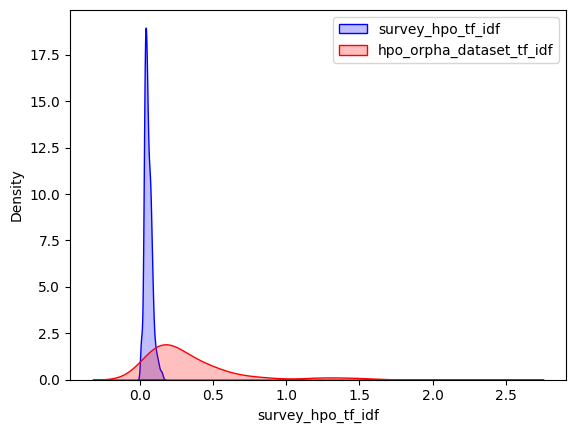

In [251]:
sns.kdeplot(rx_orphanet['survey_hpo_tf_idf'], shade=True, color="b")
sns.kdeplot(rx_orphanet['hpo_orpha_dataset_tf_idf'], shade=True, color="r")
plt.legend(('survey_hpo_tf_idf', 'hpo_orpha_dataset_tf_idf'))
plt.show()

# Step 6: Analyze and make Conclusions

We call a term 'new' if it is not found in hpo/orphanet dataset.
We call a term 'top terms' which has higher survey_hpo_tf_idf_value than average.

### Look at diseases with an Orphanet entry

In [252]:
#we analyze here Kleefstra syndrome for Orphanet entry
dis_orpha = rx_orphanet_summary.loc[rx_orphanet_summary.index==rx_in_orphanet[0]]

The following terms are new and top terms for the Disease 1/Robinow syndrome. We see 'Abnormal dental pulp morphology', 'Cranial asymmetry', 'Abnormal delivery', 'Bladder neoplasm', .. from the follwing lists are new or different from hpo or orphanet dataset. 

In [253]:
dis_orpha[dis_orpha['NewRareX']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 1,Symptom 130,34.0,0.607143,0.021212,HP:0006479,Abnormal dental pulp morphology,0.157782,Frequent (79-30%),NaN,NaN,...,[37.5],8.361011e-20,1,1,1,0,0,0,0,"[[Tooth malposition, 1]]"
Disease 1,Symptom 209,32.0,0.571429,0.021790,HP:0000267,Cranial asymmetry,0.153154,Frequent (79-30%),NaN,NaN,...,NaN,2.310184e-18,1,1,0,1,0,0,0,[]
Disease 1,Symptom 54,31.0,0.553571,0.015019,HP:0001787,Abnormal delivery,0.149950,Frequent (79-30%),NaN,NaN,...,NaN,1.155092e-17,1,1,0,1,0,0,0,[]
Disease 1,Symptom 193,30.0,0.535714,0.022369,HP:0009725,Bladder neoplasm,0.148766,Frequent (79-30%),NaN,NaN,...,NaN,5.597753e-17,1,1,0,1,0,0,0,[]
Disease 1,Symptom 8,30.0,0.535714,0.024610,HP:0002087,Abnormality of the upper respiratory tract,0.147763,Frequent (79-30%),NaN,NaN,...,NaN,5.597753e-17,1,1,0,1,0,0,0,[]
Disease 1,Symptom 147,30.0,0.535714,0.014535,HP:0000080,Abnormality of reproductive system physiology,0.145113,Frequent (79-30%),NaN,NaN,...,NaN,5.597753e-17,1,1,0,1,0,0,0,[]
Disease 1,Symptom 18,35.0,0.625000,0.028711,HP:0000587,Abnormal optic nerve morphology,0.141451,Frequent (79-30%),NaN,NaN,...,NaN,1.507723e-20,1,1,0,1,0,0,0,[]
Disease 1,Symptom 55,29.0,0.517857,0.021623,HP:0002686,Pregnancy history,0.140672,Frequent (79-30%),NaN,NaN,...,NaN,2.633017e-16,1,1,0,1,0,0,0,[]
Disease 1,Symptom 84,32.0,0.571429,0.019964,HP:0012719,Functional abnormality of the gastrointestinal...,0.137755,Frequent (79-30%),NaN,NaN,...,NaN,2.310184e-18,1,1,0,1,0,0,0,[]


The following new terms which are top terms for the Disease 1/Robinow syndrome show that Abnormal dental pulp morphology, Abnormal delivery, Abnormality of the upper respiratory tract, .. are common. These terms are important terms for the Kleefstra syndrome but not exist/matched in the hpo/orpha dataset. 

In [254]:
dis_orpha[dis_orpha['top_terms_not_match_but_frequent']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 1,Symptom 209,32.0,0.571429,0.021790,HP:0000267,Cranial asymmetry,0.153154,Frequent (79-30%),NaN,NaN,...,NaN,2.310184e-18,1,1,0,1,0,0,0,[]
Disease 1,Symptom 54,31.0,0.553571,0.015019,HP:0001787,Abnormal delivery,0.149950,Frequent (79-30%),NaN,NaN,...,NaN,1.155092e-17,1,1,0,1,0,0,0,[]
Disease 1,Symptom 193,30.0,0.535714,0.022369,HP:0009725,Bladder neoplasm,0.148766,Frequent (79-30%),NaN,NaN,...,NaN,5.597753e-17,1,1,0,1,0,0,0,[]
Disease 1,Symptom 8,30.0,0.535714,0.024610,HP:0002087,Abnormality of the upper respiratory tract,0.147763,Frequent (79-30%),NaN,NaN,...,NaN,5.597753e-17,1,1,0,1,0,0,0,[]
Disease 1,Symptom 147,30.0,0.535714,0.014535,HP:0000080,Abnormality of reproductive system physiology,0.145113,Frequent (79-30%),NaN,NaN,...,NaN,5.597753e-17,1,1,0,1,0,0,0,[]
Disease 1,Symptom 18,35.0,0.625000,0.028711,HP:0000587,Abnormal optic nerve morphology,0.141451,Frequent (79-30%),NaN,NaN,...,NaN,1.507723e-20,1,1,0,1,0,0,0,[]
Disease 1,Symptom 55,29.0,0.517857,0.021623,HP:0002686,Pregnancy history,0.140672,Frequent (79-30%),NaN,NaN,...,NaN,2.633017e-16,1,1,0,1,0,0,0,[]
Disease 1,Symptom 84,32.0,0.571429,0.019964,HP:0012719,Functional abnormality of the gastrointestinal...,0.137755,Frequent (79-30%),NaN,NaN,...,NaN,2.310184e-18,1,1,0,1,0,0,0,[]
Disease 1,Symptom 178,28.0,0.500000,0.017469,HP:0011443,Abnormality of coordination,0.135439,Frequent (79-30%),NaN,NaN,...,NaN,1.203665e-15,1,1,0,1,0,0,0,[]


Disease 1/Robinow syndrome show agreement for Constipation, Sleep disturbance whcih are are common in hpo and survey dataset.

In [255]:
dis_orpha[dis_orpha['matched_terms_frequent_both']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 1,Symptom 95,30.0,0.535714,0.017185,HP:0004322,Short stature,0.060366,Frequent (79-30%),Very frequent (99-80%),89.5,...,35.0,6.879691e-07,0,0,0,0,1,0,0,[]


The following top terms for the Disease 1/Robinow syndrome has the higher frequency in suvey than their matched/similar terms in the hpo/orphanet dataset show that Abnormal repetitive mannerisms has higher frequency in survey data. 

In [256]:
dis_orpha.loc[dis_orpha['top_matched_terms_frequent_survey_only']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 1,Symptom 171,29.0,0.517857,0.019747,HP:0000410,Mixed hearing impairment,0.112714,Frequent (79-30%),Very rare (<4-1%),2.5,...,52.0,9.435807e-14,1,0,1,0,0,1,0,[]


The following top terms for the Disease 1/Robinow syndrome but has the higher term proportion difference with their matched/similar terms than average show that Functional abnormality of the gastrointestinal, Abnormal curvature of the vertebral column, Abnormality of the nose have higher proportional difference. 

In [257]:
dis_orpha.loc[dis_orpha['top_hpo_term_prop_diff']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 1,Symptom 130,34.0,0.607143,0.021212,HP:0006479,Abnormal dental pulp morphology,0.157782,Frequent (79-30%),NaN,NaN,...,[37.5],8.361011e-20,1,1,1,0,0,0,0,"[[Tooth malposition, 1]]"
Disease 1,Symptom 102,30.0,0.535714,0.020428,HP:0005294,Arterial dissection,0.128616,Frequent (79-30%),NaN,NaN,...,[37.5],5.597753e-17,1,1,1,0,0,0,0,"[[Coarctation of aorta, 1]]"
Disease 1,Symptom 41,27.0,0.482143,0.016845,HP:0010674,Abnormal curvature of the vertebral column,0.121534,Frequent (79-30%),NaN,NaN,...,[37.5],5.354234e-15,1,1,1,0,0,0,0,"[[Scoliosis, 1]]"
Disease 1,Symptom 65,29.0,0.517857,0.018092,HP:0000366,Abnormality of the nose,0.115101,Frequent (79-30%),NaN,NaN,...,[37.5],2.633017e-16,1,1,1,0,0,0,0,"[[Short nose, 1]]"
Disease 1,Symptom 171,29.0,0.517857,0.019747,HP:0000410,Mixed hearing impairment,0.112714,Frequent (79-30%),Very rare (<4-1%),2.5,...,52.0,9.435807e-14,1,0,1,0,0,1,0,[]


These terms for the Disease 1/Robinow syndrome such as 'Exaggerated cupid's bow', 'Tented upper lip vermilion', 'Everted lower lip vermilion, 'Malar flattening', .. are common in hpo with high tf_idf score but not found in survey data.

In [258]:
dis_orpha.loc[dis_orpha['Found_only_in_HPO']==1].sort_values(by ='hpo_orpha_dataset_tf_idf', ascending=False)

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 1,NaN,NaN,NaN,NaN,HP:0003027,Mesomelia,NaN,NaN,Very frequent (99-80%),89.5,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 1,NaN,NaN,NaN,NaN,HP:0005011,Mesomelic arm shortening,NaN,NaN,Frequent (79-30%),54.5,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 1,NaN,NaN,NaN,NaN,HP:0003086,Acromesomelia,NaN,NaN,Frequent (79-30%),54.5,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 1,NaN,NaN,NaN,NaN,HP:0003241,External genital hypoplasia,NaN,NaN,Frequent (79-30%),54.5,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 1,NaN,NaN,NaN,NaN,HP:0001518,Small for gestational age,NaN,NaN,Frequent (79-30%),54.5,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 1,NaN,NaN,NaN,NaN,HP:0000316,Hypertelorism,NaN,NaN,Frequent (79-30%),54.5,...,0,1.0,0,0,0,0,0,0,1,[]


The following terms for the Disease 1/Robinow syndrome are the similar terms with other symptoms which are not found in the orphanet or hpo dataset. The number defines the number of the times the term is found similar with other terms.

In [259]:
common_matched_terms = count_matched_term(rx_orphanet_summary)[rx_in_orphanet[0]]
common_matched_terms = [[Ontology.get_hpo_object(term).name, count] for term, count in common_matched_terms]
common_matched_terms

[['Neurodevelopmental delay', 2],
 ['Tooth malposition', 1],
 ['Coarctation of aorta', 1],
 ['Scoliosis', 1],
 ['Short nose', 1],
 ['Short stature', 1]]

### Diseases with HPO entry
diseases which have not been found in orphanet

In [260]:
#we analyze here CHAMP1 related disorders for HPO entry
dis_hpo = rx_hpo_only_summary.loc[rx_hpo_only_summary.index==rx_in_hpo[1]]

The following terms are new and top terms for the Disease 7/Kabuki syndrome 2. We see 'Pregnancy exposure', 'Cervical neoplasm', 'Abnormality of the musculature of the limbs', 'leep onset insomnia' .. from the follwing lists are new or different from hpo or orphanet dataset. 

In [262]:
dis_hpo[dis_hpo['NewRareX']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 7,Symptom 57,39.0,0.619048,0.020996,HP:0031437,Pregnancy exposure,0.132401,Frequent (79-30%),NaN,NaN,...,NaN,2.401112e-21,1,1,0,1,0,0,0,[]
Disease 7,Symptom 189,38.0,0.603175,0.014286,HP:0032241,Cervical neoplasm,0.127733,Frequent (79-30%),NaN,NaN,...,NaN,1.200556e-20,1,1,0,1,0,0,0,[]
Disease 7,Symptom 35,36.0,0.571429,0.014740,HP:0009127,Abnormality of the musculature of the limbs,0.117575,Frequent (79-30%),NaN,NaN,...,NaN,2.736652e-19,1,1,0,1,0,0,0,[]
Disease 7,Symptom 215,37.0,0.587302,0.013910,HP:0031354,Sleep onset insomnia,0.113591,Frequent (79-30%),NaN,NaN,...,NaN,5.818078e-20,1,1,0,1,0,0,0,[]
Disease 7,Symptom 14,33.0,0.523810,0.014747,HP:0000517,Abnormal lens morphology,0.113267,Frequent (79-30%),NaN,NaN,...,NaN,2.411489e-17,1,1,0,1,0,0,0,[]
Disease 7,Symptom 125,35.0,0.555556,0.015641,HP:0025124,Fragile teeth,0.112418,Frequent (79-30%),NaN,NaN,...,NaN,1.251041e-18,1,1,0,1,0,0,0,[]
Disease 7,Symptom 59,32.0,0.507937,0.015659,HP:0010881,Abnormality of the umbilical cord,0.111194,Frequent (79-30%),NaN,NaN,...,NaN,1.019049e-16,1,1,0,1,0,0,0,[]
Disease 7,Symptom 54,35.0,0.555556,0.011129,HP:0001787,Abnormal delivery,0.111107,Frequent (79-30%),NaN,NaN,...,NaN,1.251041e-18,1,1,0,1,0,0,0,[]
Disease 7,Symptom 26,38.0,0.603175,0.013134,HP:0001978,Extramedullary hematopoiesis,0.105983,Frequent (79-30%),NaN,NaN,...,NaN,1.200556e-20,1,1,0,1,0,0,0,[]


The following new terms which are top terms for the Disease 7/Kabuki syndrome 2 show that Pregnancy exposure, Cervical neoplasm, Abnormality of the musculature of the limbs, 	Sleep onset insomnia are common. These terms are important terms for the Kleefstra syndrome but not exist/similar to the term in the hpo/orpha dataset. 

In [263]:
dis_hpo[dis_hpo['top_terms_not_match_but_frequent']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 7,Symptom 57,39.0,0.619048,0.020996,HP:0031437,Pregnancy exposure,0.132401,Frequent (79-30%),NaN,NaN,...,NaN,2.401112e-21,1,1,0,1,0,0,0,[]
Disease 7,Symptom 189,38.0,0.603175,0.014286,HP:0032241,Cervical neoplasm,0.127733,Frequent (79-30%),NaN,NaN,...,NaN,1.200556e-20,1,1,0,1,0,0,0,[]
Disease 7,Symptom 35,36.0,0.571429,0.014740,HP:0009127,Abnormality of the musculature of the limbs,0.117575,Frequent (79-30%),NaN,NaN,...,NaN,2.736652e-19,1,1,0,1,0,0,0,[]
Disease 7,Symptom 215,37.0,0.587302,0.013910,HP:0031354,Sleep onset insomnia,0.113591,Frequent (79-30%),NaN,NaN,...,NaN,5.818078e-20,1,1,0,1,0,0,0,[]
Disease 7,Symptom 14,33.0,0.523810,0.014747,HP:0000517,Abnormal lens morphology,0.113267,Frequent (79-30%),NaN,NaN,...,NaN,2.411489e-17,1,1,0,1,0,0,0,[]
Disease 7,Symptom 125,35.0,0.555556,0.015641,HP:0025124,Fragile teeth,0.112418,Frequent (79-30%),NaN,NaN,...,NaN,1.251041e-18,1,1,0,1,0,0,0,[]
Disease 7,Symptom 59,32.0,0.507937,0.015659,HP:0010881,Abnormality of the umbilical cord,0.111194,Frequent (79-30%),NaN,NaN,...,NaN,1.019049e-16,1,1,0,1,0,0,0,[]
Disease 7,Symptom 54,35.0,0.555556,0.011129,HP:0001787,Abnormal delivery,0.111107,Frequent (79-30%),NaN,NaN,...,NaN,1.251041e-18,1,1,0,1,0,0,0,[]
Disease 7,Symptom 26,38.0,0.603175,0.013134,HP:0001978,Extramedullary hematopoiesis,0.105983,Frequent (79-30%),NaN,NaN,...,NaN,1.200556e-20,1,1,0,1,0,0,0,[]


Disease 7/Kabuki syndrome 2 related disorders show agreement for Hearing impairment, Seizure, Intellectual disability, SIntellectual disability whcih are common in hpo and survey dataset.

In [264]:
dis_hpo[dis_hpo['matched_terms_frequent_both']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 7,Symptom 202,37.0,0.587302,0.012788,HP:0000365,Hearing impairment,0.055704,Frequent (79-30%),Frequent (79-30%),33.333333,...,21.166667,1.950094e-03,0,0,0,0,1,0,0,[]
Disease 7,Symptom 185,33.0,0.523810,0.013511,HP:0001250,Seizure,0.040702,Frequent (79-30%),Frequent (79-30%),33.333333,...,21.166667,2.151700e-02,0,0,0,0,1,0,0,[]
Disease 7,Symptom 200,33.0,0.523810,0.011406,HP:0001249,Intellectual disability,0.040323,Frequent (79-30%),Very frequent (99-80%),100.000000,...,45.5,1.694168e-15,0,0,0,0,1,0,0,[]


The following top terms for the Disease 7/Kabuki syndrome 2 but has the higher term proportion difference with their matched/similar terms than average show that Tooth malposition, Arterial dissection, CAbnormal hair morphology, .. have different proportion. 

In [265]:
dis_hpo.loc[dis_hpo['top_hpo_term_prop_diff']==1]

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 7,Symptom 131,39.0,0.619048,0.017429,HP:0000692,Tooth malposition,0.100280,Frequent (79-30%),NaN,NaN,...,[38.94444444444444],2.401112e-21,1,1,1,0,0,0,0,"[[Dental malocclusion, 1]]"
Disease 7,Symptom 102,34.0,0.539683,0.015194,HP:0005294,Arterial dissection,0.095663,Frequent (79-30%),NaN,NaN,...,[41.166666666666664],5.564974e-18,1,1,1,0,0,0,0,"[[Coarctation of aorta, 1]]"
Disease 7,Symptom 61,38.0,0.603175,0.015559,HP:0001595,Abnormal hair morphology,0.090113,Frequent (79-30%),NaN,NaN,...,[21.16666666666667],1.200556e-20,1,1,1,0,0,0,0,"[[Hirsutism, 1]]"


These terms such as 'Areolar fullness', 'Prominent fingertip pads', 'Eversion of lateral third of lower eyelids' .. are common in hpo with high tf_idf score but not found in survey data.

In [266]:
dis_hpo.loc[dis_hpo['Found_only_in_HPO']==1].sort_values(by ='hpo_orpha_dataset_tf_idf', ascending=False)

,Symptom,Count,term_proportion,survey_tf_idf,HPO_Code,HPO_label,survey_hpo_tf_idf,Survey_OrphaClass,HPO_Frequency_OrphaClass,HPO_Count,...,abs_hpo_term_prop_difference,fisher_value,top_terms,NewRareX,top_hpo_term_prop_diff,top_terms_not_match_but_frequent,matched_terms_frequent_both,top_matched_terms_frequent_survey_only,Found_only_in_HPO,matched_terms_count
Disease_Name,,,,,,,,,,,,,,,,,,,,,
Disease 7,NaN,NaN,NaN,NaN,HP:0032315,Areolar fullness,NaN,NaN,Very frequent (99-80%),100.000000,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 7,NaN,NaN,NaN,NaN,HP:0001212,Prominent fingertip pads,NaN,NaN,Very frequent (99-80%),100.000000,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 7,NaN,NaN,NaN,NaN,HP:0007655,Eversion of lateral third of lower eyelids,NaN,NaN,Very frequent (99-80%),80.000000,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 7,NaN,NaN,NaN,NaN,HP:0000637,Long palpebral fissure,NaN,NaN,Very frequent (99-80%),100.000000,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 7,NaN,NaN,NaN,NaN,HP:0008897,Postnatal growth retardation,NaN,NaN,Very frequent (99-80%),100.000000,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 7,NaN,NaN,NaN,NaN,HP:0000437,Depressed nasal tip,NaN,NaN,Frequent (79-30%),75.000000,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 7,NaN,NaN,NaN,NaN,HP:0002000,Short columella,NaN,NaN,Frequent (79-30%),66.666667,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 7,NaN,NaN,NaN,NaN,HP:0000400,Macrotia,NaN,NaN,Very frequent (99-80%),90.909091,...,0,1.0,0,0,0,0,0,0,1,[]
Disease 7,NaN,NaN,NaN,NaN,HP:0008872,Feeding difficulties in infancy,NaN,NaN,Very frequent (99-80%),84.000000,...,0,1.0,0,0,0,0,0,0,1,[]


The following terms for Disease 7/Kabuki syndrome 2 are the similar terms with other symptoms which are not found in the orphanet or hpo dataset. The number defines the number of the times the term is found similar with other terms.

In [267]:
common_matched_terms = count_matched_term(rx_hpo_only_summary)[rx_in_hpo[0]]
common_matched_terms = [[Ontology.get_hpo_object(term).name, count] for term, count in common_matched_terms]
common_matched_terms

[]

### Multiple diseases
We analyze here following disease Disease 8/'Dystonia 28, childhood-onset' in hpo dataset. There are multple disease have been mapped with Disease 8, we analyze here Familial paroxysmal ataxia mapped disease.  

In [270]:
rx_dis_name = rx_in_mult[0]
mapped_mult_dis_name = rarex_multiple_dis_mapping[rx_dis_name][0]
dis_mult = rx_multi_disease_summary.loc[rx_multi_disease_summary.index==(rx_dis_name, mapped_mult_dis_name)]


The following terms are new and top terms for Disease 8/'Dystonia 28, childhood-onset'. We see 'Abnormality of the musculature of the limbs', 'Abnormality of coordination', 'Abnormal dental root morphology' .. from the follwing lists are new or different from hpo or orphanet dataset.

In [272]:
dis_mult[dis_mult['NewRareX']==1]

Symptom  Count  \
Disease_Name Mapped_Disease_name                                
Disease 8    Dystonia 28, childhood-onset   Symptom 35   35.0   
             Dystonia 28, childhood-onset  Symptom 178   36.0   
             Dystonia 28, childhood-onset  Symptom 129   31.0   
             Dystonia 28, childhood-onset   Symptom 38   32.0   
             Dystonia 28, childhood-onset  Symptom 218   29.0   
...                                                ...    ...   
             Dystonia 28, childhood-onset   Symptom 71   27.0   
             Dystonia 28, childhood-onset   Symptom 26   24.0   
             Dystonia 28, childhood-onset  Symptom 111   30.0   
             Dystonia 28, childhood-onset  Symptom 101   24.0   
             Dystonia 28, childhood-onset  Symptom 220   27.0   

                                           term_proportion  survey_tf_idf  \
Disease_Name Mapped_Disease_name                                            
Disease 8    Dystonia 28, childhood-onset         0.583333       0.012099   
             Dystonia 28, childhood-onset         0.600000       0.012445   
             Dystonia 28, childhood-onset         0.516667       0.012808   
             Dystonia 28, childhood-onset         0.533333       0.012074   
             Dystonia 28, childhood-onset         0.483333       0.010025   
...                                                    ...            ...   
             Dystonia 28, childhood-onset         0.450000       0.010187   
             Dystonia 28, childhood-onset         0.400000       0.007004   
             Dystonia 28, childhood-onset         0.500000       0.010371   
             Dystonia 28, childhood-onset         0.400000       0.009916   
             Dystonia 28, childhood-onset         0.450000       0.011155   

                                             HPO_Code  \
Disease_Name Mapped_Disease_name                        
Disease 8    Dystonia 28, childhood-onset  HP:0009127   
             Dystonia 28, childhood-onset  HP:0011443   
             Dystonia 28, childhood-onset  HP:0006486   
             Dystonia 28, childhood-onset  HP:0100285   
             Dystonia 28, childhood-onset  HP:0025236   
...                                               ...   
             Dystonia 28, childhood-onset  HP:0000873   
             Dystonia 28, childhood-onset  HP:0001978   
             Dystonia 28, childhood-onset  HP:0000953   
             Dystonia 28, childhood-onset  HP:0003115   
             Dystonia 28, childhood-onset  HP:0010535   

                                                                             HPO_label  \
Disease_Name Mapped_Disease_name                                                         
Disease 8    Dystonia 28, childhood-onset  Abnormality of the musculature of the limbs   
             Dystonia 28, childhood-onset                  Abnormality of coordination   
             Dystonia 28, childhood-onset              Abnormal dental root morphology   
             Dystonia 28, childhood-onset     EMG: impaired neuromuscular transmission   
             Dystonia 28, childhood-onset                                 Somnambulism   
...                                                                                ...   
             Dystonia 28, childhood-onset                           Diabetes insipidus   
             Dystonia 28, childhood-onset                 Extramedullary hematopoiesis   
             Dystonia 28, childhood-onset                Hyperpigmentation of the skin   
             Dystonia 28, childhood-onset                                 Abnormal EKG   
             Dystonia 28, childhood-onset                                  Sleep apnea   

                                           survey_hpo_tf_idf  \
Disease_Name Mapped_Disease_name                               
Disease 8    Dystonia 28, childhood-onset           0.096510   
             Dystonia 28, childhood-onset           0.096488   
             Dystonia 28, chil

The following new terms which are top terms for the Disease 8/'Dystonia 28, childhood-onset' show that Abnormality of the musculature of the limb, Abnormality of coordination, Abnormal dental root morphology  are common. These terms are important terms for the Familial paroxysmal ataxia but not exist/similar to the term in the hpo/orpha dataset. 

In [275]:
dis_mult[dis_mult['top_terms_not_match_but_frequent']==1]

Symptom  Count  \
Disease_Name Mapped_Disease_name                                
Disease 8    Dystonia 28, childhood-onset   Symptom 35   35.0   
             Dystonia 28, childhood-onset  Symptom 178   36.0   
             Dystonia 28, childhood-onset  Symptom 129   31.0   
             Dystonia 28, childhood-onset   Symptom 38   32.0   
             Dystonia 28, childhood-onset  Symptom 218   29.0   
...                                                ...    ...   
             Dystonia 28, childhood-onset   Symptom 71   27.0   
             Dystonia 28, childhood-onset   Symptom 26   24.0   
             Dystonia 28, childhood-onset  Symptom 111   30.0   
             Dystonia 28, childhood-onset  Symptom 101   24.0   
             Dystonia 28, childhood-onset  Symptom 220   27.0   

                                           term_proportion  survey_tf_idf  \
Disease_Name Mapped_Disease_name                                            
Disease 8    Dystonia 28, childhood-onset         0.583333       0.012099   
             Dystonia 28, childhood-onset         0.600000       0.012445   
             Dystonia 28, childhood-onset         0.516667       0.012808   
             Dystonia 28, childhood-onset         0.533333       0.012074   
             Dystonia 28, childhood-onset         0.483333       0.010025   
...                                                    ...            ...   
             Dystonia 28, childhood-onset         0.450000       0.010187   
             Dystonia 28, childhood-onset         0.400000       0.007004   
             Dystonia 28, childhood-onset         0.500000       0.010371   
             Dystonia 28, childhood-onset         0.400000       0.009916   
             Dystonia 28, childhood-onset         0.450000       0.011155   

                                             HPO_Code  \
Disease_Name Mapped_Disease_name                        
Disease 8    Dystonia 28, childhood-onset  HP:0009127   
             Dystonia 28, childhood-onset  HP:0011443   
             Dystonia 28, childhood-onset  HP:0006486   
             Dystonia 28, childhood-onset  HP:0100285   
             Dystonia 28, childhood-onset  HP:0025236   
...                                               ...   
             Dystonia 28, childhood-onset  HP:0000873   
             Dystonia 28, childhood-onset  HP:0001978   
             Dystonia 28, childhood-onset  HP:0000953   
             Dystonia 28, childhood-onset  HP:0003115   
             Dystonia 28, childhood-onset  HP:0010535   

                                                                             HPO_label  \
Disease_Name Mapped_Disease_name                                                         
Disease 8    Dystonia 28, childhood-onset  Abnormality of the musculature of the limbs   
             Dystonia 28, childhood-onset                  Abnormality of coordination   
             Dystonia 28, childhood-onset              Abnormal dental root morphology   
             Dystonia 28, childhood-onset     EMG: impaired neuromuscular transmission   
             Dystonia 28, childhood-onset                                 Somnambulism   
...                                                                                ...   
             Dystonia 28, childhood-onset                           Diabetes insipidus   
             Dystonia 28, childhood-onset                 Extramedullary hematopoiesis   
             Dystonia 28, childhood-onset                Hyperpigmentation of the skin   
             Dystonia 28, childhood-onset                                 Abnormal EKG   
             Dystonia 28, childhood-onset                                  Sleep apnea   

                                           survey_hpo_tf_idf  \
Disease_Name Mapped_Disease_name                               
Disease 8    Dystonia 28, childhood-onset           0.096510   
             Dystonia 28, childhood-onset           0.096488   
             Dystonia 28, chil

Disease 8/'Dystonia 28, childhood-onset' show agreement for Microcephaly,Short stature  whcih are common in hpo and survey dataset.

In [277]:
dis_mult[dis_mult['matched_terms_frequent_both']==1]

Symptom  Count  \
Disease_Name Mapped_Disease_name                                
Disease 8    Dystonia 28, childhood-onset  Symptom 208   29.0   
             Dystonia 28, childhood-onset   Symptom 95   28.0   

                                           term_proportion  survey_tf_idf  \
Disease_Name Mapped_Disease_name                                            
Disease 8    Dystonia 28, childhood-onset         0.483333       0.010942   
             Dystonia 28, childhood-onset         0.466667       0.008887   

                                             HPO_Code      HPO_label  \
Disease_Name Mapped_Disease_name                                       
Disease 8    Dystonia 28, childhood-onset  HP:0000252   Microcephaly   
             Dystonia 28, childhood-onset  HP:0004322  Short stature   

                                           survey_hpo_tf_idf  \
Disease_Name Mapped_Disease_name                               
Disease 8    Dystonia 28, childhood-onset           0.034651   
             Dystonia 28, childhood-onset           0.031219   

                                           Survey_OrphaClass  \
Disease_Name Mapped_Disease_name                               
Disease 8    Dystonia 28, childhood-onset  Frequent (79-30%)   
             Dystonia 28, childhood-onset  Frequent (79-30%)   

                                          HPO_Frequency_OrphaClass  HPO_Count  \
Disease_Name Mapped_Disease_name                                                
Disease 8    Dystonia 28, childhood-onset        Frequent (79-30%)  66.666667   
             Dystonia 28, childhood-onset        Frequent (79-30%)  50.000000   

                                           ...  abs_hpo_term_prop_difference  \
Disease_Name Mapped_Disease_name           ...                                 
Disease 8    Dystonia 28, childhood-onset  ...                     12.166667   
             Dystonia 28, childhood-onset  ...                           4.5   

                                          fisher_value  top_terms  NewRareX  \
Disease_Name Mapped_Disease_name                                              
Disease 8    Dystonia 28, childhood-onset     0.029910          0         0   
             Dystonia 28, childhood-onset     0.744886          0         0   

                                           top_hpo_term_prop_diff  \
Disease_Name Mapped_Disease_name                                    
Disease 8    Dystonia 28, childhood-onset                       0   
             Dystonia 28, childhood-onset                       0   

                                          top_terms_not_match_but_frequent  \
Disease_Name Mapped_Disease_name                                             
Disease 8    Dystonia 28, childhood-onset                                0   
             Dystonia 28, childhood-onset                                0   

                                          matched_terms_frequent_both  \
Disease_Name Mapped_Disease_name                                        
Disease 8    Dystonia 28, childhood-onset                           1   
             Dystonia 28, childhood-onset                           1   

                                          top_matched_terms_frequent_survey_only  \
Disease_Name Mapped_Disease_name                                                   
Disease 8    Dystonia 28, childhood-onset                                      0   
             Dystonia 28, childhood-onset                                      0   

                                          Found_only_in_HPO  \
Disease_Name Mapped_Disease_name                              
Disease 8    Dystonia 28, childhood-onset                 0   
             Dystonia 28, childhood-onset                 0   

                                           matched_terms_count  
Disease_Name Mapped_Disease_name                                
Disease 8    Dystonia 28, childhood-onset                   []  
             Dystonia 28, childhood-onset  

The following top terms for the Disease 8/'Dystonia 28, childhood-onset' but has the higher term proportion difference with their matched/similar terms than average show that Diminished movement, Cerebral palsy, Abnormality of movement	 .. have different proportion. 

In [279]:
dis_mult.loc[dis_mult['top_hpo_term_prop_diff']==1]

Symptom  Count  \
Disease_Name Mapped_Disease_name                                
Disease 8    Dystonia 28, childhood-onset  Symptom 213   31.0   
             Dystonia 28, childhood-onset  Symptom 175   32.0   
             Dystonia 28, childhood-onset  Symptom 204   31.0   

                                           term_proportion  survey_tf_idf  \
Disease_Name Mapped_Disease_name                                            
Disease 8    Dystonia 28, childhood-onset         0.516667       0.012808   
             Dystonia 28, childhood-onset         0.533333       0.011062   
             Dystonia 28, childhood-onset         0.516667       0.012808   

                                             HPO_Code  \
Disease_Name Mapped_Disease_name                        
Disease 8    Dystonia 28, childhood-onset  HP:0002374   
             Dystonia 28, childhood-onset  HP:0100021   
             Dystonia 28, childhood-onset  HP:0100022   

                                                         HPO_label  \
Disease_Name Mapped_Disease_name                                     
Disease 8    Dystonia 28, childhood-onset      Diminished movement   
             Dystonia 28, childhood-onset           Cerebral palsy   
             Dystonia 28, childhood-onset  Abnormality of movement   

                                           survey_hpo_tf_idf  \
Disease_Name Mapped_Disease_name                               
Disease 8    Dystonia 28, childhood-onset           0.081804   
             Dystonia 28, childhood-onset           0.063096   
             Dystonia 28, childhood-onset           0.058474   

                                           Survey_OrphaClass  \
Disease_Name Mapped_Disease_name                               
Disease 8    Dystonia 28, childhood-onset  Frequent (79-30%)   
             Dystonia 28, childhood-onset  Frequent (79-30%)   
             Dystonia 28, childhood-onset  Frequent (79-30%)   

                                          HPO_Frequency_OrphaClass  HPO_Count  \
Disease_Name Mapped_Disease_name                                                
Disease 8    Dystonia 28, childhood-onset                      NaN        NaN   
             Dystonia 28, childhood-onset                      NaN        NaN   
             Dystonia 28, childhood-onset                      NaN        NaN   

                                           ...  abs_hpo_term_prop_difference  \
Disease_Name Mapped_Disease_name           ...                                 
Disease 8    Dystonia 28, childhood-onset  ...                        [45.5]   
             Dystonia 28, childhood-onset  ...          [37.833333333333336]   
             Dystonia 28, childhood-onset  ...                        [45.5]   

                                           fisher_value  top_terms  NewRareX  \
Disease_Name Mapped_Disease_name                                               
Disease 8    Dystonia 28, childhood-onset  9.929551e-17          1         1   
             Dystonia 28, childhood-onset  2.232225e-17          1         1   
             Dystonia 28, childhood-onset  9.929551e-17          1         1   

                                           top_hpo_term_prop_diff  \
Disease_Name Mapped_Disease_name                                    
Disease 8    Dystonia 28, childhood-onset                       1   
             Dystonia 28, childhood-onset                       1   
             Dystonia 28, childhood-onset                       1   

                                          top_terms_not_match_but_frequent  \
Disease_Name Mapped_Disease_name                                             
Disease 8    Dystonia 28, childhood-onset                                0   
             Dystonia 28, childhood-onset                                0   
             Dystonia 28, childhood-onset                                0   

                                          matched_terms_frequent_both  \
Disease_Name Mapped_Disease_name      

These terms such as 'Dystonia', 'Intellectual disability, mild', 'Juvenile onset',  .. are common in hpo with high tf_idf score for Familial paroxysmal ataxia but not found in survey data.

In [281]:
dis_mult.loc[dis_mult['Found_only_in_HPO']==1].sort_values(by ='hpo_orpha_dataset_tf_idf', ascending=False)

Symptom  Count  term_proportion  \
Disease_Name Mapped_Disease_name                                            
Disease 8    Dystonia 28, childhood-onset     NaN    NaN              NaN   
             Dystonia 28, childhood-onset     NaN    NaN              NaN   
             Dystonia 28, childhood-onset     NaN    NaN              NaN   
             Dystonia 28, childhood-onset     NaN    NaN              NaN   
             Dystonia 28, childhood-onset     NaN    NaN              NaN   
             Dystonia 28, childhood-onset     NaN    NaN              NaN   
             Dystonia 28, childhood-onset     NaN    NaN              NaN   
             Dystonia 28, childhood-onset     NaN    NaN              NaN   

                                           survey_tf_idf    HPO_Code  \
Disease_Name Mapped_Disease_name                                       
Disease 8    Dystonia 28, childhood-onset            NaN  HP:0001332   
             Dystonia 28, childhood-onset            NaN  HP:0001256   
             Dystonia 28, childhood-onset            NaN  HP:0003621   
             Dystonia 28, childhood-onset            NaN  HP:0000483   
             Dystonia 28, childhood-onset            NaN  HP:0000750   
             Dystonia 28, childhood-onset            NaN  HP:0001263   
             Dystonia 28, childhood-onset            NaN  HP:0001270   
             Dystonia 28, childhood-onset            NaN  HP:0011463   

                                                                         HPO_label  \
Disease_Name Mapped_Disease_name                                                     
Disease 8    Dystonia 28, childhood-onset                                 Dystonia   
             Dystonia 28, childhood-onset            Intellectual disability, mild   
             Dystonia 28, childhood-onset                           Juvenile onset   
             Dystonia 28, childhood-onset                              Astigmatism   
             Dystonia 28, childhood-onset  Delayed speech and language development   
             Dystonia 28, childhood-onset               Global developmental delay   
             Dystonia 28, childhood-onset                              Motor delay   
             Dystonia 28, childhood-onset                          Childhood onset   

                                           survey_hpo_tf_idf  \
Disease_Name Mapped_Disease_name                               
Disease 8    Dystonia 28, childhood-onset                NaN   
             Dystonia 28, childhood-onset                NaN   
             Dystonia 28, childhood-onset                NaN   
             Dystonia 28, childhood-onset                NaN   
             Dystonia 28, childhood-onset                NaN   
             Dystonia 28, childhood-onset                NaN   
             Dystonia 28, childhood-onset                NaN   
             Dystonia 28, childhood-onset                NaN   

                                          Survey_OrphaClass  \
Disease_Name Mapped_Disease_name                              
Disease 8    Dystonia 28, childhood-onset               NaN   
             Dystonia 28, childhood-onset               NaN   
             Dystonia 28, childhood-onset               NaN   
             Dystonia 28, childhood-onset               NaN   
             Dystonia 28, childhood-onset               NaN   
             Dystonia 28, childhood-onset               NaN   
             Dystonia 28, childhood-onset               NaN   
             Dystonia 28, childhood-onset               NaN   

                                          HPO_Frequency_OrphaClass  \
Disease_Name Mapped_Disease_name                                     
Disease 8    Dystonia 28, childhood-onset   Very frequent (99-80%)   
             Dystonia 28, childhood-onset        Frequent (79-30%)   
             Dystonia 28, childhood-onset        Frequent (79-30%)   
             Dystonia 28, childhood-onset        Frequent (79-30%) 

The following terms are the similar terms with other symptoms which are not found in the orphanet or hpo dataset for Disease 8/'Dystonia 28, childhood-onset'. The number defines the number of the times the term is found similar with other terms.

In [282]:
common_matched_terms = count_matched_term(rx_multi_disease_summary)[rx_dis_name]
common_matched_terms = [[Ontology.get_hpo_object(term).name, count] for term, count in common_matched_terms]
common_matched_terms

[['Gastroesophageal reflux', 5],
 ['Dysphagia', 4],
 ['Autistic behavior', 4],
 ['Intellectual disability', 3],
 ['Dystonia', 2],
 ['Tremor', 2],
 ['Strabismus', 2],
 ['High palate', 2],
 ['Attention deficit hyperactivity disorder', 2],
 ['Ptosis', 2],
 ['Global developmental delay', 1],
 ['Motor delay', 1],
 ['Intellectual disability, mild', 1],
 ['Epicanthus', 1],
 ['Sparse hair', 1],
 ['Intrauterine growth retardation', 1],
 ['Hypothyroidism', 1],
 ['Neurodevelopmental delay', 1]]